In [1]:
import torch                        
import torch.nn as nn               
import torch.nn.functional as F     

from sklearn.model_selection import train_test_split
import scikitplot as skplt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

print("Train data shape:", train_data.shape)
print("Test data shape:", test.shape)

Train data shape: (42000, 785)
Test data shape: (28000, 784)


In [3]:
train_all = train_data.iloc[:,1:]     
train_all_label = train_data["label"] 


train_all_numpy = train_all.to_numpy()
train_all_label_numpy = train_all_label.to_numpy()
test_numpy = test.to_numpy()

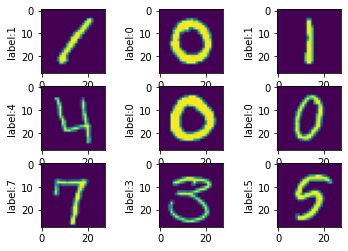

In [4]:
def plot_img(data, label):
    fig, axs = plt.subplots(3, 3) 
    k = 0
    for i in range(3):
        for j in range(3):        
            axs[i, j].imshow(data[k].astype('uint8').reshape(28, 28))              
            axs[i, j].set_ylabel("label:" + str(label[k].item()))       
            k +=1
plot_img(train_all_numpy, train_all_label_numpy)

In [5]:
train, validation, train_label, validation_label = train_test_split(train_all_numpy, train_all_label_numpy, test_size=0.2)

print(train.shape)
print(train_label.shape)
print(validation.shape)
print(validation_label.shape)

(33600, 784)
(33600,)
(8400, 784)
(8400,)


In [6]:
train_all_tensor = torch.as_tensor(train_all_numpy).type(torch.FloatTensor)
train_all_label_tensor = torch.as_tensor(train_all_label_numpy)
test_tensor = torch.as_tensor(test_numpy).type(torch.FloatTensor)

train_tensor = torch.as_tensor(train).type(torch.FloatTensor)
train_label = torch.as_tensor(train_label)

validation_tensor = torch.as_tensor(validation).type(torch.FloatTensor)
validation_label = torch.as_tensor(validation_label)

In [7]:
class FNet(nn.Module):             
    def __init__(self):
        super(FNet, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=500) 
        self.fc3 = nn.Linear(in_features=500, out_features=250) 
        self.fc4 = nn.Linear(in_features=250, out_features=10)  
                                                                
    def forward(self, x):
        x = x.view(-1,784)          
        x = F.relu(self.fc1(x))     
                                    
        x = F.relu(self.fc2(x))        
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x   

In [8]:
def get_accuracy(predictions, true_labels):
    _, predicted = torch.max(predictions, 1)
    corrects = (predicted == true_labels).sum()
    accuracy = 100.0 * corrects/len(true_labels)
    return accuracy.item()

In [9]:
def training (dataloader, epochs, model, criterion, optimizer):

    train_accuracies, train_losses = [], []
    
    model.train()
    
    for epoch in range(epochs):        

        train_loss = 0 
        train_accuracy = 0
        num_batch = 0
        
        for data, labels in dataloader:
            
            optimizer.zero_grad()
            
            predictions = net(data)
            
            loss = criterion(predictions, labels)
            
            accurasy = get_accuracy(predictions, labels)
            
            loss.backward()
            
            optimizer.step()
            
            num_batch += 1
            train_loss += loss.item()
            train_accuracy += accurasy
    
        epoch_accuracy = train_accuracy/num_batch
        epoch_loss = train_loss/num_batch        
        train_accuracies.append(epoch_accuracy)
        train_losses.append(epoch_loss)
        
        print("Epoch: {}/{} ".format(epoch + 1, epochs),
              "Training Loss: {:.4f} ".format(epoch_loss),
              "Training accuracy: {:.4f}".format(epoch_accuracy))
    
    return train_accuracies, train_losses

In [10]:
from typing import Any, Callable, Dict, Iterable, Optional, Tuple, Union

from torch import Tensor

Params = Union[Iterable[Tensor], Iterable[Dict[str, Any]]]

LossClosure = Callable[[], float]
OptLossClosure = Optional[LossClosure]
Betas2 = Tuple[float, float]
State = Dict[str, Any]
OptFloat = Optional[float]
Nus2 = Tuple[float, float]

In [11]:
import math

import torch
from torch.optim.optimizer import Optimizer


__all__ = ('DiffGrad',)


class CustomGrad(Optimizer):

    def __init__(
        self,
        params: Params,
        lr: float = 1e-3,
        betas: Betas2 = (0.9, 0.999),
        eps: float = 1e-8,
        weight_decay: float = 0.0,
    ) -> None:
        if lr <= 0.0:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if eps < 0.0:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(
                'Invalid beta parameter at index 0: {}'.format(betas[0])
            )
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(
                'Invalid beta parameter at index 1: {}'.format(betas[1])
            )
        if weight_decay < 0.0:
            raise ValueError(
                'Invalid weight_decay value: {}'.format(weight_decay)
            )

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(DiffGrad, self).__init__(params, defaults)

    def step(self, closure: OptLossClosure = None) -> OptFloat:

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    msg = (
                        'CustomGrad does not support sparse gradients, '
                        'please consider SparseAdam instead'
                    )
                    raise RuntimeError(msg)

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )
                    # Previous gradient
                    state['previous_grad'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )

                exp_avg, exp_avg_sq, previous_grad = (
                    state['exp_avg'],
                    state['exp_avg_sq'],
                    state['previous_grad'],
                )

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # compute diffgrad coefficient (dfc)
                diff = torch.abs(previous_grad - grad)
                dfc = torch.div(1.0, (1.0 + torch.exp(-diff)))
                state['previous_grad'] = grad.clone()

                # update momentum with dfc
                exp_avg1 = exp_avg * dfc

                step_size = (
                    group['lr']
                    * math.sqrt(bias_correction2)
                    / bias_correction1
                )

                p.data.addcdiv_(exp_avg1, denom, value=-step_size)

        return 

In [13]:
torch.manual_seed(0)                                      # set seed to make results reproducible

batch_size = 128                                          # Set the batch_size
train_dataset = torch.utils.data.TensorDataset(train_tensor, train_label)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)


epochs = 40                                               # set number of epohs

net = FNet()                                              # initialize network
criterion = nn.CrossEntropyLoss()                         # set criterion
optimizer = DiffGrad(net.parameters(), lr = 3e-4) # set optimizer

                                                          # start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

Epoch: 1/40  Training Loss: 0.3153  Training accuracy: 90.6399
Epoch: 2/40  Training Loss: 0.0965  Training accuracy: 97.0324
Epoch: 3/40  Training Loss: 0.0479  Training accuracy: 98.5118
Epoch: 4/40  Training Loss: 0.0280  Training accuracy: 99.1267
Epoch: 5/40  Training Loss: 0.0158  Training accuracy: 99.5812
Epoch: 6/40  Training Loss: 0.0095  Training accuracy: 99.7683
Epoch: 7/40  Training Loss: 0.0120  Training accuracy: 99.6792
Epoch: 8/40  Training Loss: 0.0195  Training accuracy: 99.3079
Epoch: 9/40  Training Loss: 0.0203  Training accuracy: 99.3197
Epoch: 10/40  Training Loss: 0.0135  Training accuracy: 99.5425
Epoch: 11/40  Training Loss: 0.0079  Training accuracy: 99.7534
Epoch: 12/40  Training Loss: 0.0111  Training accuracy: 99.6435
Epoch: 13/40  Training Loss: 0.0162  Training accuracy: 99.5188
Epoch: 14/40  Training Loss: 0.0095  Training accuracy: 99.6911
Epoch: 15/40  Training Loss: 0.0090  Training accuracy: 99.7297
Epoch: 16/40  Training Loss: 0.0135  Training acc

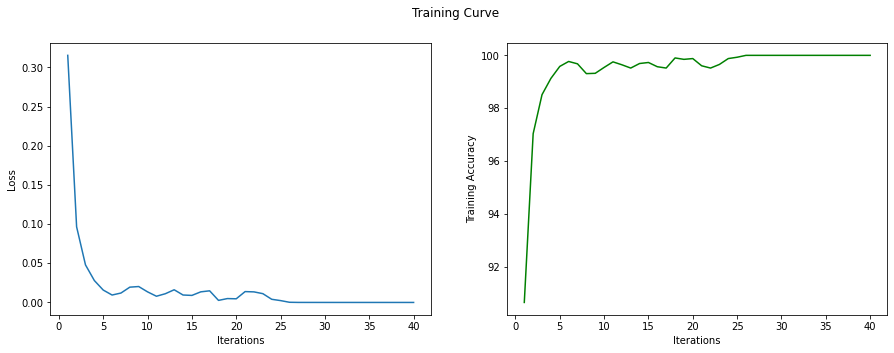

In [14]:
def train_curves(epochs, train_losses, train_accuracies):
    iters = range(1, epochs+1)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    fig.suptitle('Training Curve')
    ax1.plot(iters, train_losses)
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax2.plot(iters, train_accuracies, color = 'g')
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Training Accuracy")
    plt.show()
    
train_curves(epochs, train_losses, train_accuracies)

Loss:  0.1161712259054184 Accuracy:  98.0952377319336


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

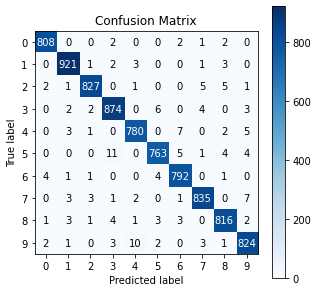

In [15]:
net.eval()    
val_predictions = net(validation_tensor)
val_loss = criterion(val_predictions, validation_label)
val_accurasy = get_accuracy(val_predictions, validation_label)
 
print("Loss: ", str(val_loss.item()), "Accuracy: ", str(val_accurasy))

_, val_predicted = torch.max(val_predictions.data,1)            

skplt.metrics.plot_confusion_matrix(validation_label, val_predicted, figsize=(5,5))

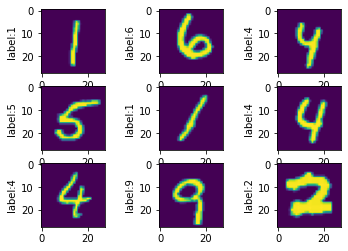

In [16]:
plot_img(validation, val_predicted)

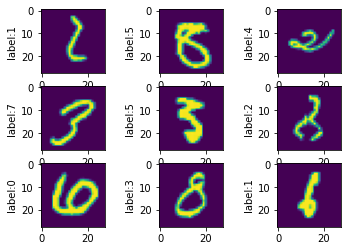

In [17]:
val_wrong = validation[validation_label != val_predicted]
val_lab_wrong = val_predicted[validation_label != val_predicted]

plot_img(val_wrong, val_lab_wrong)

In [18]:
torch.manual_seed(0)                                      # set seed to make results reproducible

batch_size = 128                                          # Set the batch_size
train_all_dataset = torch.utils.data.TensorDataset(train_all_tensor, train_all_label_tensor)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

epochs = 40                                               # set number of epohs

net = FNet()                                              # initialize network
criterion = nn.CrossEntropyLoss()                         # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

                                                          # start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

Epoch: 1/40  Training Loss: 0.2918  Training accuracy: 91.5756
Epoch: 2/40  Training Loss: 0.0894  Training accuracy: 97.1602
Epoch: 3/40  Training Loss: 0.0520  Training accuracy: 98.3157
Epoch: 4/40  Training Loss: 0.0362  Training accuracy: 98.8237
Epoch: 5/40  Training Loss: 0.0276  Training accuracy: 99.1326
Epoch: 6/40  Training Loss: 0.0302  Training accuracy: 98.9365
Epoch: 7/40  Training Loss: 0.0240  Training accuracy: 99.2158
Epoch: 8/40  Training Loss: 0.0276  Training accuracy: 99.0791
Epoch: 9/40  Training Loss: 0.0186  Training accuracy: 99.4089
Epoch: 10/40  Training Loss: 0.0171  Training accuracy: 99.5069
Epoch: 11/40  Training Loss: 0.0187  Training accuracy: 99.3584
Epoch: 12/40  Training Loss: 0.0201  Training accuracy: 99.3138
Epoch: 13/40  Training Loss: 0.0232  Training accuracy: 99.3079
Epoch: 14/40  Training Loss: 0.0246  Training accuracy: 99.2158
Epoch: 15/40  Training Loss: 0.0125  Training accuracy: 99.6198
Epoch: 16/40  Training Loss: 0.0123  Training acc